In [32]:
import cdf_sampler as cds
import numpy as np
from examples import gauss
import matplotlib.pyplot as plt

## Problem: you want to draw random values from a distribution that is neither Gaussian nor uniform

## Solution: use my inverse cumulative distribution sampler! 

First create an arbitrary x and y array. Here I'm just adding two gaussians and a line. This is the arbitrary function we want to draw from.


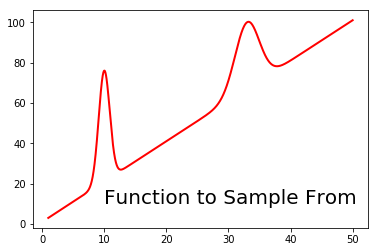

In [33]:
x = np.arange(1.,50.,.001)
y1= gauss(x,55.,10.,.5)
y2= gauss(x,33.,33.,1.1)
y3= 1.+2.*x
y = y1+y2+y3

f = plt.figure()
ax= f.add_subplot(111)
ax.plot(x,y,'r-',lw=2)
ax.annotate('Function to Sample From',xy=(10,10),fontsize=20)
plt.show()

## In **cdf_sampler.py** you will use the primary class to create your sampler object:

Simply call the cdf_sampler class with your x and y arrays as the two arguments (first line below). When the function is initiallised, it uses **numpy.cumsum** to create the cumulative distribution function (CDF) normalised by the sum of the y array. 

**NOTE: be sure that you have covered the full range in x that is relevant to the problem you are using this code for!! This is a naive sampler, it relies on you understanding the problem you are trying to solve**

You can then create your sample of N psuedo-random values by using sampler_object.sample_n(N). But what is it actually doing? This is just a standard inverse CDF sampling: 

1. Create the normalised CDF
2. Uniformly sample random values between 0 and 1
3. Find where your random value is equal to your CDF
4. Add the corresponding x-value to your sample
5. Repeat until you have a sample of N values

This process is illustrated in the plots below.

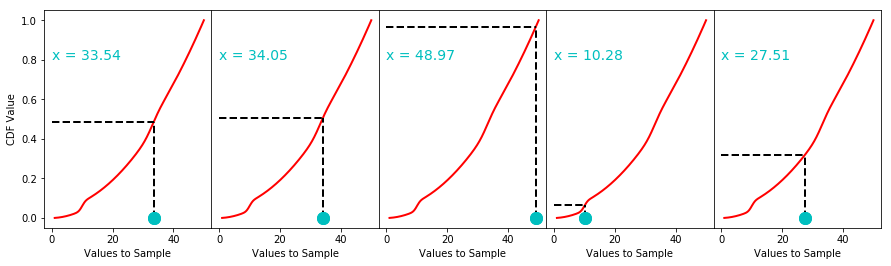

In [34]:
sampler = cds.cdf_sampler(x,y)

f = plt.figure(figsize=(15,4))
for i in range(5):
    tm   = np.random.uniform()
    tt   = np.where(np.abs(tm-sampler.cdf) == np.min(np.abs(tm-sampler.cdf)))
    tx   = x[tt[0]]
    tx   = tx[0]
    xlab = str((round(tx*100)/100))
    
    ax= f.add_subplot(1,5,i+1)
    ax.plot(x,sampler.cdf,'r-',lw=2)
    ax.plot([0,tx],[tm,tm],'k--',lw=2)
    ax.plot([tx,tx],[0,tm],'k--',lw=2)
    ax.plot([tx,tx],[0,0],'co',ms=12)
    ax.annotate('x = '+xlab,xy=(0,.8),color='c',fontsize=14)
    ax.set_xlabel('Values to Sample')
    if i == 0:
        ax.set_ylabel('CDF Value')
    else:
        ax.set_yticks([])
    
plt.subplots_adjust(wspace=0.0)
plt.show()

## Now we sample!

We have created our sampler object and called it "sampler", we can create a sample of N values based on the input function by calling "sampler.sample_n(N)"

This is done below using N=10000. The plots show the input function overplotted on a histogram of the sampled values. They match!

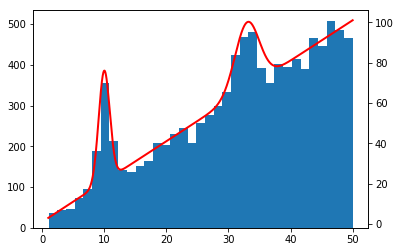

In [37]:
sampler.sample_n(10000)

f = plt.figure()
ax= f.add_subplot(111)
xa= ax.twinx()
ax.hist(sampler.sample,bins=35)
xa.plot(x,y,'r-',lw=2)
plt.show()

## The code is also equipped to handle probability distributions with zeros

Why is this a problem? If you have portions of your input x array where the corresponding y array is zero, the corresponding CDF will be flat at these locations (see below). If you sample the CDF at that value, it corresponds to multiple x values; how do you know which to choose?? 

The solution: if you know for certain that the probability is **truly** zero in these x ranges, then you don't want to select _any_ value here. In cdf_sampler, it is clear this happens because multiple x values are returned. When this happens, cdf_sampler does a random binomial sample (either 0 or 1). For 0 it returns the last x value corresponding to a non-zero y value and for 1 it selects the next x value corresponding to a non-zero y value. 

This is illustrated below where a new sampler is created using only the Gaussian portions of the previous sampler (i.e. the linear part is removed). 

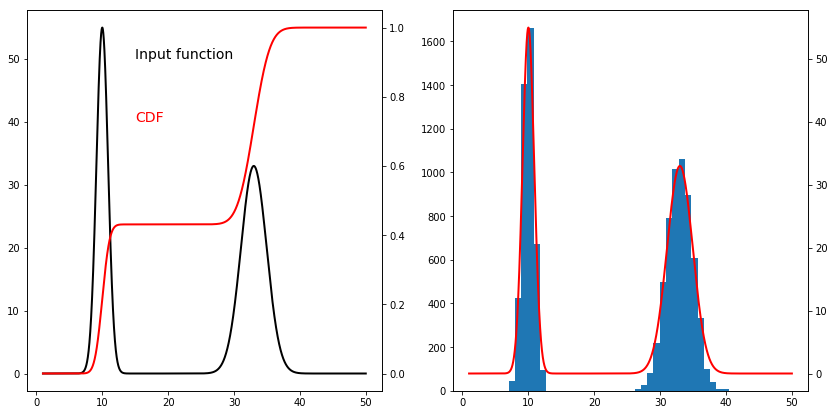

In [38]:
y = y1+y2
sampler = cds.cdf_sampler(x,y)
sampler.sample_n(10000)

f = plt.figure(figsize=(14,7))
ax= f.add_subplot(121)
ax.plot(x,y,'k-',lw=2)
ax.annotate('Input function',xy=(15,50),fontsize=14)
ax.annotate('CDF',xy=(15,40),color='r',fontsize=14)
xa=ax.twinx()
xa.plot(x,sampler.cdf,'r-',lw=2)

ax= f.add_subplot(122)
xa= ax.twinx()
ax.hist(sampler.sample,bins=35)
xa.plot(x,y,'r-',lw=2)
plt.show()

## What if I want to resample based on a histogram and I don't necessarily know the functional form it corresponds to??

You're in luck! There's a subclass for that: **cdf_sampler.histogram_oversampler**!

Below we'll read in some data. What it is is not important, we simply want to use it to create a histogram. The goal is to create a new sample of values that, when binned in the same way, will match this input histogram.

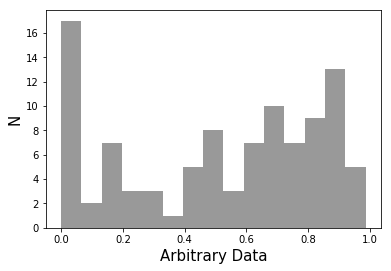

In [25]:
test_data = np.load('z3p5_100tau.npy')
t911      = np.exp((-1.)*test_data[:,140])

f  = plt.figure()
ax = f.add_subplot(111)
ax.hist(t911,bins=15,histtype='stepfilled',color='k',lw=3,alpha=.4)
ax.set_xlabel('Arbitrary Data',fontsize=15)
ax.set_ylabel('N',fontsize=15)
plt.show()


To use the **histogram_oversampler** subclass we need to create the histogram data using "y,bin_edges = numpy.histogram". This will be the inputs to the subclass. You may prefer not to only output values associated with the bin centres, however, so **histogram_oversampler** allows you to include an "oversampling factor". This will simply determine how many linearly spaced values can be selected within each bin. Here we will use an oversampling factor of 100 and again create a sample of 10000 values. 

_(Here you can see why this is useful! You may produce your histogram from, say, a sample of 1000 values, but you want a sample of 10000)_

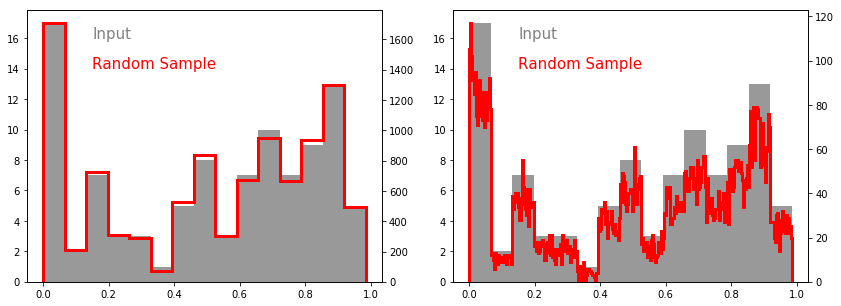

In [30]:
y,bin_edges = np.histogram(t911,bins=15)
sampler = cds.histogram_oversampler(bin_edges,y,100)
sampler.sample_n(10000)

f  = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
ax.hist(t911,bins=15,histtype='stepfilled',color='k',lw=3,alpha=.4)
ax.annotate('Input',xy=(.15,16),fontsize=15,color='grey')
ax.annotate('Random Sample',xy=(.15,14),color='r',fontsize=15)
xa = ax.twinx()
xa.hist(sampler.sample,bins=15,histtype='step',color='r',lw=3)

ax = f.add_subplot(122)
ax.hist(t911,bins=15,histtype='stepfilled',color='k',lw=3,alpha=.4)
ax.annotate('Input',xy=(.15,16),fontsize=15,color='grey')
ax.annotate('Random Sample',xy=(.15,14),color='r',fontsize=15)
xa = ax.twinx()
xa.hist(sampler.sample,bins=300,histtype='step',color='r',lw=3)
plt.show()

**_Above_**: To the left we show histograms of the input and output data with the same binning, but remember that we oversampled the input histogram by a factor of 100. On the right, we show the same binning for the input histogram, but now plot the output data with 20x more bins. You can see that the output is slightly below the input, but this is just due to the increased number of bins and the y-axis scaling. Hopefully the left panel convinces you we have properly matched the input sample!

Finally, perhaps you don't like the fact that the output distribution retains the "blockiness" of the input histogram (i.e. the sharp rises and drops from bin to bin). You're in luck again! There is an included optional kwarg in **histogram_oversampler** called "spline" (defaulted to False). Setting "spline=True" will fit the input histogram with a spline using **scipy.interpolate.interp1d** (kind='cubic') and initialises the CDF sampler using the fit rather than the histogram data. Lets give it a go!

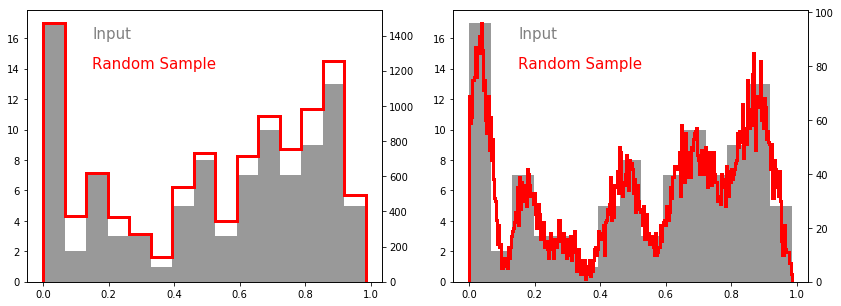

In [31]:
sampler = cds.histogram_oversampler(bin_edges,y,100,spline=True)
sampler.sample_n(10000)

f  = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
ax.hist(t911,bins=15,histtype='stepfilled',color='k',lw=3,alpha=.4)
ax.annotate('Input',xy=(.15,16),fontsize=15,color='grey')
ax.annotate('Random Sample',xy=(.15,14),color='r',fontsize=15)
xa = ax.twinx()
xa.hist(sampler.sample,bins=15,histtype='step',color='r',lw=3)

ax = f.add_subplot(122)
ax.hist(t911,bins=15,histtype='stepfilled',color='k',lw=3,alpha=.4)
ax.annotate('Input',xy=(.15,16),fontsize=15,color='grey')
ax.annotate('Random Sample',xy=(.15,14),color='r',fontsize=15)
xa = ax.twinx()
xa.hist(sampler.sample,bins=300,histtype='step',color='r',lw=3)
plt.show()

# **DISCLAIMER!!!!!!**

Use **cdf_sampler** and **histogram_oversampler** at your own risk. I describe these functions as "naive samplers" because they don't care at all what is input into them. Understanding the consequences of their usage is up to you! If you want to use these to do science, you must understand very well your data, what you hope to achieve, and what unintentional artefacts may arise when using these functions to achieve that!

R. Bassett (19/7/19)